In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ex_comparison_forecasting

Mounted at /content/drive
/content/drive/MyDrive/ex_comparison_forecasting


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import math
import sklearn.preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import pickle
from scipy import interpolate
import random
import time
from lightgbm import LGBMRegressor
# import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2


In [ ]:
dict_R2 = {}
list_ex = ['ex1','ex2', 'ex3', 'ex4', 'ex5', '3Dex1', '3Dex2', '3Dex3', '3Dex4', '3Dex5' ]
ex_name = '3Dex5'

### Data_processing

In [ ]:

with open(f'EQall.p','rb') as f:
  EQall = pickle.load(f)

with open(f'new_p_data_allEQ_{ex_name}.p', 'rb') as f:
  df_new = pickle.load(f)

for i in range(len(df_new)):
  L = len(df_new['disp_ground'][i])
  if L >3000:
    df_new['disp_ground'][i] = df_new['disp_ground'][i][:3000]
  else:
    df_new['disp_ground'][i] = list(df_new['disp_ground'][i]) + [0]*(3000-L)

In [ ]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P


In [ ]:
list_output_time = []
list_static = []

for k in list(df_new):
  if (str(k)[:4] == 'disp') & (str(k)[-1] != 'd'):
    list_output_time.append(k)

  if str(k)[:4] != 'disp':
    list_static.append(k)

print(list(df_new))
print(len(df_new))

['fc', 'Ec', 'Fy', 'Es', 'damp', 'g', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

In [ ]:
with open(f'list_EQ_id.p', 'rb') as f:
    list_EQid = pickle.load(f)

df_new['EQid'] = list_EQid
list_len = np.array([len(df_new['disp_2'][ip]) for ip in range(len(df_new))])
list_idx = np.where(list_len!=3000)[0]
df_new = df_new.drop(index=list_idx)
df_new = df_new.reset_index()

In [ ]:
L_signal_input = len(df_new['disp_ground'][0])
L_ground = L_signal_input

Ndim_encoding = 2
P_encoding = getPositionEncoding(seq_len=L_signal_input, d=Ndim_encoding, n=10000)
list_input_time = ['disp_ground']+[f'encode_{d}' for d in range(Ndim_encoding)]
# list_input_time = ['disp_ground']

print(list_input_time)
print(list_output_time)

['disp_ground', 'encode_0', 'encode_1']
['disp_2', 'disp_3', 'disp_4', 'disp_5', 'disp_6', 'disp_7', 'disp_8', 'disp_9']


In [ ]:
for d in range(Ndim_encoding):
  df_new[f'encode_{d}'] = [P_encoding[:,d]]*len(df_new)


In [ ]:
L_all, L_out = 800, 750
sliding_step = 750
list_time_series = list_input_time + list_output_time
L_in = L_all-L_out
N_input= len(list_input_time)
N_output= len(list_output_time)
N_static = len(list_static)
N_all = N_input+N_output+N_static
N_time_series = len(list_input_time)+len(list_output_time)+1

max_disp = [np.max(np.abs(df_new[list_output_time[-1]][idx])) for idx in range(len(df_new))]
df_new['max_disp'] = max_disp


In [ ]:
static_scaler = sklearn.preprocessing.StandardScaler().fit(df_new[list_static].values)
target = np.array([df_new[i][0] for i in list_output_time]).T
target_scaler = sklearn.preprocessing.StandardScaler().fit(target)
real = np.array([df_new[i][0] for i in list_time_series]).T
real_scaler = sklearn.preprocessing.StandardScaler().fit(real)

In [ ]:
def prepare_data_batch(x, N1, N2, j = 2):
  N0 = np.shape(x)[1]
  xxx = np.stack([x[:,i:N0 - N1+i+1:j, :] for i in range(N1)], axis=2)
  y = xxx[:,:,-N2:,-len(list_output_time):]

  return np.array(xxx), np.array(y)

In [ ]:
gc.collect(2)
gc.collect(2)

0

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import pandas as pd


In [ ]:
class h_Dataset(Dataset):
    def __init__(self, data_time, data_static, data_y):
        self.data_time = data_time
        self.data_static = data_static
        self.data_y = data_y

    def __getitem__(self, index):
        seq_time = self.data_time[index]
        seq_static = self.data_static[index]
        seq_y = self.data_y[index]
        return seq_time, seq_static, seq_y

    def __len__(self):
        return len(self.data_y)


def data_provider2(data_x, data_y, batch_size=128):
    data_set = h_Dataset(data_x, data_y)
    data_loader = DataLoader( data_set, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_set, data_loader



In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()

        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, kernel_size=3, padding=1, padding_mode='circular', bias=False)

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
          x = self.value_embedding(x) + self.position_embedding(x)
          return self.dropout(x)

In [ ]:
class Data_aggregation(nn.Module):
    def __init__(self, dropout=0.1):
        super(Data_aggregation, self).__init__()
        self.projection = nn.Sequential(nn.Linear(N_static, L_all), nn.ReLU(), nn.Linear(L_all, L_all))
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x_time, x_static):
        x = self.projection(x_static)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = torch.cat([x_time, x], dim=2)

        return x

In [ ]:
# [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
def gen_data_AI_batch_2_model(df_new, list_idx):
  signal = [np.stack(list(df_new[k][list_idx])) for k in list_time_series ]
  signal = np.stack(signal).transpose(1,2,0)
  signal = np.pad(signal,((0,0),(L_all,0),(0,0)),constant_values=0.0)
  signal = signal.reshape(-1, N_input + N_output)
  scaled_signal = real_scaler.transform(signal)
  scaled_signal = scaled_signal.reshape(-1, L_ground+L_all, N_input + N_output)
  X_times_series, Y_label = prepare_data_batch(scaled_signal, L_all, L_out, j = sliding_step)
  X_times_series[:,:,L_in:,N_input:N_input+N_output] = 0.0

  static = np.stack(list(df_new[k][list_idx] for k in list_static)).T
  scaled_static = static_scaler.transform(static)
  X_static = scaled_static.reshape(-1,1,1,N_static)
  X_static = np.tile(X_static, [1, X_times_series.shape[1], 1, 1])
  X_times_series = X_times_series.reshape(-1, L_all, N_input+N_output)
  X_static = X_static.reshape(-1, 1, N_static)
  Y_label =  Y_label.reshape(-1, L_out, N_output)

  return X_times_series, X_static, Y_label



In [ ]:
# idx_train = np.random.choice(len(df_new), size=500, replace=False)  # False: 1 value 1 time
# idx_valid = np.random.choice(len(df_new), size=2000, replace=False)  # False: 1 value 1 time

idx_train = np.random.choice(len(df_new), size=200, replace=False)
idx_valid = [i for i in range(len(df_new)) if i not in idx_train]

print(len(idx_train), len(idx_valid))
train_time, train_static, train_label = gen_data_AI_batch_2_model(df_new, idx_train)
val_time, val_static, val_label = gen_data_AI_batch_2_model(df_new, idx_valid)
print(train_time.shape, train_static.shape, train_label.shape)
print(val_time.shape, val_static.shape, val_label.shape)


200 54
(1000, 800, 11) (1000, 1, 284) (1000, 750, 8)
(270, 800, 11) (270, 1, 284) (270, 750, 8)


In [ ]:
def data_provider2(data_time, data_static, data_y, batch_size=128):
    data_set = h_Dataset(data_time, data_static, data_y)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_set, data_loader


In [ ]:
_, train_loader = data_provider2(train_time, train_static, train_label, batch_size=64)
_, valid_loader = data_provider2(val_time, val_static, val_label, batch_size=64)


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, configs):
        super(ResBlock, self).__init__()

        self.temporal = nn.Sequential(
            nn.Linear(L_all, configs.d_model),
            nn.ReLU(),
            nn.Linear(configs.d_model, L_all),
            nn.Dropout(configs.dropout)
        )

        self.channel = nn.Sequential(
            nn.Linear(N_input+N_output+1, configs.d_model),
            nn.ReLU(),
            nn.Linear(configs.d_model, N_input+N_output+1),
            nn.Dropout(configs.dropout)
        )

    def forward(self, x):
        # x: [B, L, D]
        x = x + self.temporal(x.transpose(1, 2)).transpose(1, 2)
        x = x + self.channel(x)

        return x


class TSMixer_dis(nn.Module):
    def __init__(self, configs):
        super(TSMixer_dis, self).__init__()
        self.layer = configs.e_layers
        self.model = nn.ModuleList([ResBlock(configs) for _ in range(configs.e_layers)])
        self.projection = nn.Sequential(nn.Linear(L_all, L_out), nn.ReLU())
        self.out_layer = nn.ModuleList([nn.Linear(N_input+N_output+1, N_output, bias=False) for i in range(7)])

    def forward(self, x_enc):
        x = x_enc
        for i in range(self.layer):
            x = self.model[i](x)

        x = self.projection(x.permute(0, 2, 1)).permute(0, 2, 1)
        x_out = torch.stack([self.out_layer[i](x) for i in range(7)], dim=-1)

        return x_out


class model_parameters:
  def __init__(self):
    self.d_model = 128
    self.e_layers = 2
    self.dropout = 0.1


args = model_parameters()
model_tor = TSMixer_dis(args)

In [ ]:
N_epoch = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
aggregation = Data_aggregation()
aggregation = aggregation.float().to(device)
model_tor = model_tor.float().to(device)
model_optim = torch.optim.Adam(list(model_tor.parameters())+list(aggregation.parameters()), lr=0.001)

# [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
class MAE_2():
    def loss(y_pred, target):
        L = torch.zeros(1).to(device)
        for i, q in enumerate([0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]):
          errors = y_pred[:,:,:,i] - target
          L += torch.mean(torch.max((q - 1) * errors, q * errors))

        return L

criterion = MAE_2


In [ ]:
def inference_5tor(model, aggregation, df_new, list_idx, batch_size = 512):
  x_time, x_static, _ = gen_data_AI_batch_2_model(df_new, list_idx)
  x_time = x_time.reshape(len(list_idx),-1,L_all, N_input+N_output)
  x_static = x_static.reshape(len(list_idx),-1, 1, N_static)

  # initial a long output time-series with zero
  y_predict_all = np.zeros((len(x_time), L_ground+L_all, N_output))
  y_predict_low = np.zeros((len(x_time), L_ground+L_all, N_output))
  y_predict_high = np.zeros((len(x_time), L_ground+L_all, N_output))

  for j in range(int(L_ground/L_out)+1):
    x_time[:,j,:L_all, N_input:N_input+N_output] = y_predict_all[:,L_out*j:L_all+L_out*j,:]
    xt = torch.from_numpy(x_time[:,j,:,:]).float().to('cuda')
    xs = torch.from_numpy(x_static[:,j,:,:]).float().to('cuda')
    batch_x = aggregation(xt, xs)
    y_pred_all = model(batch_x).to('cuda').cpu().detach().numpy()
    y_predict_all[:,L_in+L_out*j:L_all+L_out*j,:] = y_pred_all[:,:,:,3]
    y_predict_low[:,L_in+L_out*j:L_all+L_out*j,:] = y_pred_all[:,:,:,0]
    y_predict_high[:,L_in+L_out*j:L_all+L_out*j,:] = y_pred_all[:,:,:,6]

  y_predict_all = target_scaler.inverse_transform(y_predict_all.reshape(-1, N_output))
  y_predict_all = y_predict_all.reshape(len(x_time), -1, N_output)

  y_predict_low = target_scaler.inverse_transform(y_predict_low.reshape(-1, N_output))
  y_predict_low = y_predict_low.reshape(len(x_time), -1, N_output)

  y_predict_high = target_scaler.inverse_transform(y_predict_high.reshape(-1, N_output))
  y_predict_high = y_predict_high.reshape(len(x_time), -1, N_output)


  return y_predict_all, y_predict_low, y_predict_high

### Train

In [ ]:
%%time
for epoch in range(N_epoch):
    train_loss = []
    for batch_time, batch_static, batch_y in train_loader:
        model_optim.zero_grad()
        batch_time, batch_static, batch_y = batch_time.float().to(device), batch_static.float().to(device), batch_y.float().to(device)
        batch_x = aggregation(batch_time, batch_static)
        outputs = model_tor(batch_x)
        loss = criterion.loss(outputs, batch_y)
        loss.backward()
        train_loss.append(loss.item())
        model_optim.step()

    if epoch % 2 ==0:
      valid_loss = []
      for batch_time, batch_static, batch_y in valid_loader:
        batch_time, batch_static, batch_y = batch_time.float().to(device), batch_static.float().to(device), batch_y.float().to(device)
        batch_x = aggregation(batch_time, batch_static)
        outputs = model_tor(batch_x)
        loss = criterion.loss(outputs, batch_y)

        valid_loss.append(loss.item())

      print(f"epoch: {epoch} | loss: {np.mean(train_loss)}, valid loss: {np.mean(valid_loss)}")


### Cal R2 of trained model

In [ ]:
with open(f'fullmodel_{ex_name}.p','rb') as f:
  model_tor = pickle.load(f)
  aggregation = pickle.load(f)
  idx_valid = pickle.load(f)


In [ ]:
list_idx = idx_valid
x_time, x_static, _ = gen_data_AI_batch_2_model(df_new, list_idx)
x_time = x_time.reshape(len(list_idx),-1,L_all, N_input+N_output)
x_static = x_static.reshape(len(list_idx),-1, 1, N_static)

y_predict_all = np.zeros((len(x_time), L_ground+L_all, N_output))

for j in range(int(L_ground/L_out)+1):
  x_time[:,j,:L_all, N_input:N_input+N_output] = y_predict_all[:,L_out*j:L_all+L_out*j,:]
  xt = torch.from_numpy(x_time[:,j,:,:]).float().to('cuda')
  xs = torch.from_numpy(x_static[:,j,:,:]).float().to('cuda')
  batch_x = aggregation(xt, xs)
  y_pred_all = model_tor(batch_x).to('cuda').cpu().detach().numpy()
  y_predict_all[:,L_in+L_out*j:L_all+L_out*j,:] = y_pred_all[:,:,:,3]

y_predict_all = target_scaler.inverse_transform(y_predict_all.reshape(-1, N_output))
y_predict_all = y_predict_all.reshape(len(x_time), -1, N_output)


dict_MAE = {k:[] for k in list_output_time}
dict_R2 = {k:[] for k in list_output_time}

for i_s in range(len(list_output_time)):
  for i in range(len(list_idx)):
    calMAE = MAE(df_new[list_output_time[i_s]][list_idx[i]], y_predict_all[i, L_all:L_all+L_ground,i_s])
    dict_MAE[list_output_time[i_s]].append(calMAE)
    calR2 = R2(df_new[list_output_time[i_s]][list_idx[i]], y_predict_all[i, L_all:L_all+L_ground,i_s])
    dict_R2[list_output_time[i_s]].append(calR2)

mean_MAE = [np.mean(dict_MAE[k]) for k in dict_MAE]
mean_R2 = [np.mean(dict_R2[k]) for k in dict_R2]
dict_R2[ex_name] = mean_R2[-1]
mean_R2[-1]

-32.93474237994212

In [ ]:
mean_MAE

[0.000511669120070581,
 0.0012218211691218867,
 0.0019153334500723817,
 0.0027494691738648453,
 0.0034534712724553973,
 0.0039103068834035175,
 0.004365686909753204,
 0.004806273663760967]

### Result post_processing

In [ ]:
with open(f'fullmodel_{ex_name}.p','wb') as f:
  pickle.dump(model_tor, f)
  pickle.dump(aggregation, f)
  pickle.dump(idx_valid, f)


CPU times: user 599 ms, sys: 167 ms, total: 766 ms
Wall time: 764 ms


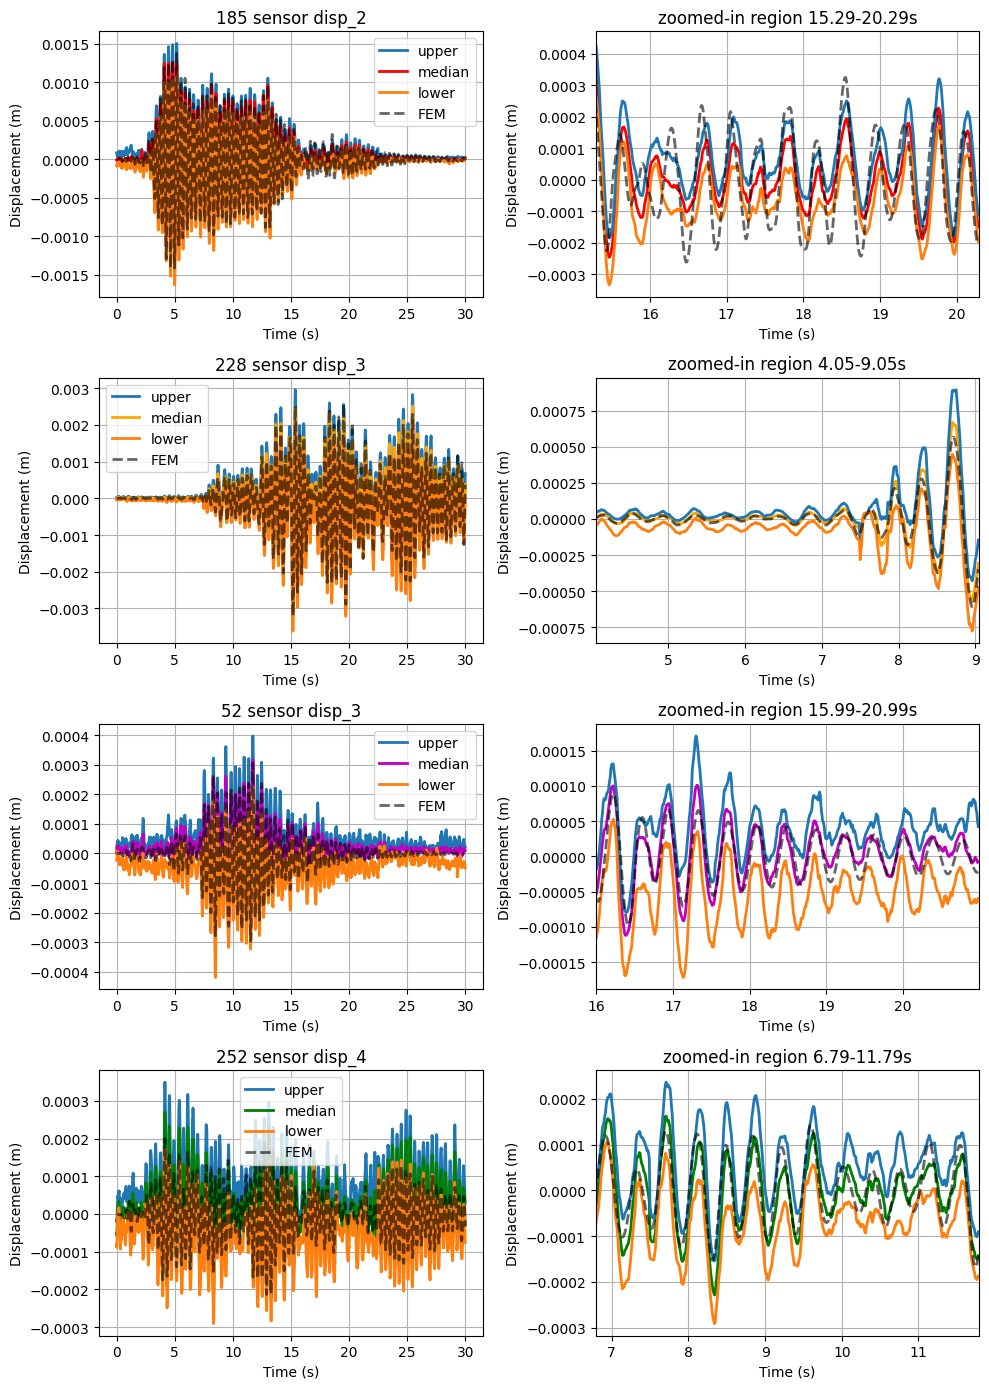

In [ ]:
%%time
plt.figure(figsize=(10,14))
list_ip = [idx_valid[i] for i in np.random.randint(0,len(idx_valid), 4)]
y_predict_all, y_predict_low, y_predict_high = inference_5tor(model_tor, aggregation, df_new, list_ip)

list_color = ['r', 'orange', 'm', 'g']
for i,ip in enumerate(list_ip):
  plt.subplot(421+i*2)
  i_s = np.random.randint(N_output)
  # i_s = 5
  length = len(df_new[list_output_time[i_s]][ip])
  t= np.arange(0,len(df_new[list_output_time[i_s]][ip][:]))*0.01
  plt.plot(t, y_predict_low[i, L_all:L_all+L_ground,i_s][:], linewidth=2)
  plt.plot(t, y_predict_all[i, L_all:L_all+L_ground,i_s][:],list_color[i], linewidth=2)
  plt.plot(t, y_predict_high[i, L_all:L_all+L_ground,i_s][:], linewidth=2)
  plt.plot(t, df_new[list_output_time[i_s]][ip][:],'--k', alpha = 0.6, linewidth=2)
  plt.legend(['upper', 'median', 'lower', 'FEM'], loc=0)
  plt.title(f'{ip} sensor {list_output_time[i_s]}', fontsize=12)
  plt.xlabel('Time (s)')
  plt.ylabel('Displacement (m)')
  # plt.ylim(-0.04, 0.04)
  # plt.xlim(0,28)
  plt.grid(True)


  plt.subplot(422+i*2)
  length = len(df_new[list_output_time[i_s]][ip])
  t= np.arange(0,len(df_new[list_output_time[i_s]][ip][:]))*0.01
  # t1, t2 = 800, 1200
  t1 = np.random.randint(0,2200)
  t2 = t1+500
  yy = y_predict_all[i, L_all:L_all+length,i_s][:]
  plt.plot(t[t1:t2], yy[t1:t2],list_color[i], linewidth=2)
  yy = y_predict_low[i, L_all:L_all+length,i_s][:]
  plt.plot(t[t1:t2], yy[t1:t2], linewidth=2)
  yy = y_predict_high[i, L_all:L_all+length,i_s][:]
  plt.plot(t[t1:t2], yy[t1:t2], linewidth=2)
  yy = df_new[list_output_time[i_s]][ip][:]
  plt.plot(t[t1:t2], yy[t1:t2],'--k', alpha = 0.6, linewidth=2)
  plt.title(f'zoomed-in region {t1/100}-{t2/100}s', fontsize=12)
  plt.xlabel('Time (s)')
  plt.ylabel('Displacement (m)')
  plt.xlim(t1*0.01, t2*0.01)
  plt.grid(True)
  # plt.ylim(-0.042, 0.042)

plt.tight_layout();
# plt.savefig(f'{ex_name}_1.png',dpi=400)

### Plot max values

In [ ]:
def maxpredict(ex_name):
  with open(f'fullmodel_{ex_name}.p','rb') as f:
    model_tor = pickle.load(f)
    aggregation = pickle.load(f)
    idx_valid = pickle.load(f)
  list_ip = idx_valid
  y_predict_all, y_predict_low, y_predict_high = inference_5tor(model_tor, aggregation, df_new, list_ip)
  y_predict_all = np.transpose(y_predict_all, (0,2,1))[:,:,L_all:]
  y_predict_low = np.transpose(y_predict_low, (0,2,1))[:,:,L_all:]
  y_predict_high = np.transpose(y_predict_high, (0,2,1))[:,:,L_all:]
  yy = np.array(df_new[list_output_time].iloc[idx_valid].values)
  y_actual = np.array([np.stack(y) for y in yy])
  y_predict_all.shape, y_actual.shape
  ymax_actual = np.max(y_actual, axis=2)
  ymax_predict = np.max(y_predict_all, axis=2)
  ymax_high = np.max(y_predict_high, axis=2)
  ymax_low = np.max(y_predict_low, axis=2)
  ymax_actual.shape
  istory = ymax_actual.shape[1]-1
  xx = np.array([0, np.max(ymax_actual[:,istory])])
  slope_high, intercept_high, _, _, _ = linregress(ymax_actual[:,istory], ymax_high[:,istory])
  y_fit_high = slope_high * xx + intercept_high
  slope_low, intercept_low, _, _, _ = linregress(ymax_actual[:,istory], ymax_low[:,istory])
  y_fit_low = slope_low * xx + intercept_low
  slope, intercept, _, _, _ = linregress(ymax_actual[:,istory], ymax_predict[:,istory])
  y_fit = slope * xx + intercept

  return (y_fit, y_fit_low, y_fit_high, ymax_actual, ymax_predict, ymax_low, ymax_high, xx, istory)

In [ ]:
xx = maxpredict(ex_name)
with open(f'max_result_{ex_name}.p', 'wb') as f:
  pickle.dump(xx,f)


In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 12
rcParams.update({'font.size': fsize})


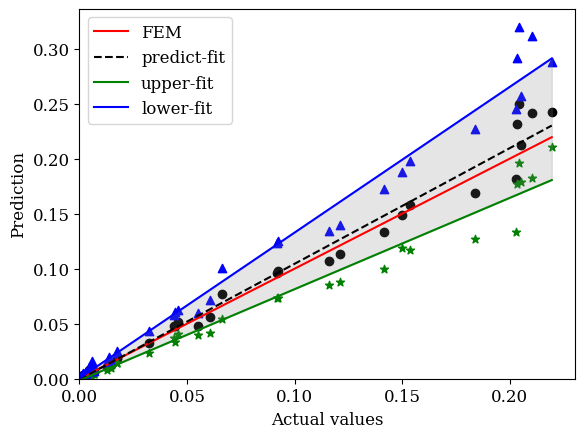

In [ ]:
y_fit, y_fit_low, y_fit_high, ymax_actual, ymax_predict, ymax_low, ymax_high, xx, istory = xx
plt.plot([np.min(ymax_actual[:,istory]), np.max(ymax_actual[:,istory])], [np.min(ymax_actual[:,istory]), np.max(ymax_actual[:,istory])], '-r',label='FEM')
plt.plot(xx, y_fit, '--k',label='predict-fit')
plt.scatter(ymax_actual[:,istory], ymax_predict[:,istory], color = 'black', marker='o')
plt.plot(xx, y_fit_high, color='green',label='upper-fit')
plt.scatter(ymax_actual[:,istory], ymax_high[:,istory], color='green', marker='*')
plt.plot(xx, y_fit_low, color='blue',label='lower-fit')
plt.scatter(ymax_actual[:,istory], ymax_low[:,istory], color='blue', marker='^')
plt.fill_between(xx, y_fit_low, y_fit_high, color="gray", alpha=0.2)
plt.xlim(0)
plt.ylim(0)
plt.legend()
plt.xlabel('Actual values')
plt.ylabel('Prediction');